# Extended CCM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance
from scipy.stats import pearsonr
from scipy.integrate import odeint

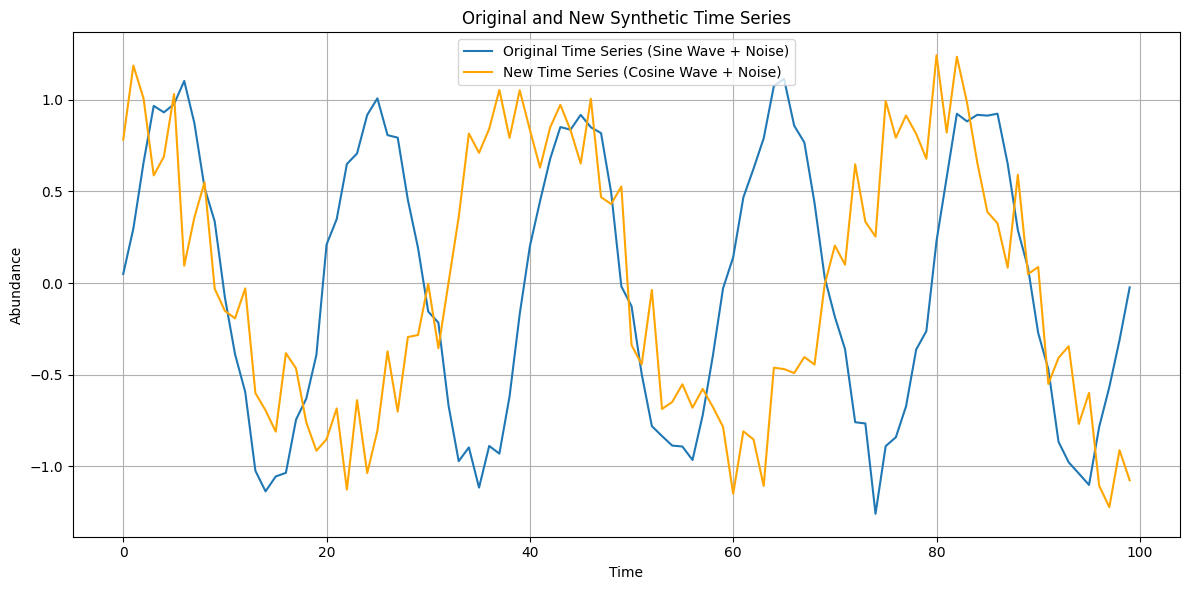

In [2]:
# Test data

L = 100  # Length of time series
E = 3    # Embedding dimension
tau = 2  # Time delay

# Generate synthetic time series data (e.g., a sine wave with some noise)
np.random.seed(42)
time_series = np.sin(np.linspace(0, 10 * np.pi, L)) + np.random.normal(0, 0.1, L)

# Create a DataFrame to store the data
data = pd.DataFrame({
    'time': np.arange(L),
    'abundance': time_series
})

np.random.seed(123)
time_series_new = np.cos(np.linspace(0, 5 * np.pi, L)) + np.random.normal(0, 0.2, L)

# Create a DataFrame to store the new data
data_new = pd.DataFrame({
    'time': np.arange(L),
    'abundance': time_series_new
})

# Plot both time series in the same plot
plt.figure(figsize=(12, 6))
plt.plot(data['time'], data['abundance'], label='Original Time Series (Sine Wave + Noise)')
plt.plot(data_new['time'], data_new['abundance'], label='New Time Series (Cosine Wave + Noise)', color='orange')
plt.xlabel('Time')
plt.ylabel('Abundance')
plt.title('Original and New Synthetic Time Series')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
# shadow manifold functiom

'''
time_series -> Data measured over time (abundance data)
L           -> Length of time series that should be concidered
E           -> Embedding dimension
tau         -> time delay

'''

def shadow_manifold(time_series_Y, L, E, tau):

    # crop data at L
    crp_ts = time_series_Y[:L]

    shadow_M = {}

    for t in range((E - 1) * tau, L): # iterate through time

        lag = [] # lagged values

        for t2 in range(0, E): # get lags - add 1 to E-1 to include E

            lag.append(time_series_Y[t - t2 * tau]) # access lagged time points and store in list

        shadow_M[t] = lag # add list to dict
    
    return shadow_M

In [4]:
# create matrix with distances between all vectors

def vec_dist_matrx (shadow_M):
    
    # seperate time steps and vectors to create arrays for cdist
    vector = []
    steps = []
    vecs = []

    for a, b in shadow_M.items():
        vector.append((a, b))

    for i in vector:
        steps.append(i[0])
        vecs.append(i[1])

    steps = np.array(steps)
    vecs = np.array(vecs)

    distance_metrics = distance.cdist(vecs, vecs, metric= "euclidean")

    return distance_metrics, steps



In [5]:
# function for dist metrics from time line

def get_dist_metr(time_series_Y, L, E, tau):

    shadow = shadow_manifold(time_series_Y, L, E, tau)
    distance_matrix, steps = vec_dist_matrx(shadow)

    return distance_matrix, steps

In [6]:
# get nearest distances and timesteps

def nearest_dist_and_step(timepoint_oi, steps, dist_matr):

    index_timepoint = np.where(steps == timepoint_oi) # get index of timepoint

    dist_timepoint = dist_matr[index_timepoint].squeeze() # distances from vector at time t (this is one row)

    # get top closest vectors
    nearest_indis = np.argsort(dist_timepoint)[1:E + 2] # sort indeces, exlude 0 (distance to itself) -> E+1+1
    
    nearest_timesteps = steps[nearest_indis]
    nearest_distances = dist_timepoint[nearest_indis]

    return nearest_timesteps, nearest_distances



In [7]:
def prediction(timepoint_oi,time_series_X, steps, dist_matrix):
        
    non_zero = 0.000001 # non zero value to avoid pproblems with dividingby zero

    index_timepoint = np.where(steps == timepoint_oi) # get the index of time t

    dist_timepoint = dist_matrix[index_timepoint].squeeze()

    nearest_timesteps, nearest_distances = nearest_dist_and_step(timepoint_oi, steps, dist_matrix)

    # get weights
    u = np.exp(-nearest_distances / np.max([non_zero, nearest_distances[0]])) # di​ wird exponentiell skaliert um Gewichtungen zu berechnen. Kleinere Distanzen führen zu größeren Gewichtungen
    w = u / np.sum(u) # divide by sum to average in total to 1 

    # get prediction of X
    X_true = time_series_X[timepoint_oi] # get corresponding true X
    X_cor = np.array(time_series_X)[nearest_timesteps] # get corresponding Y to cluster in Mx
    X_hat = (w * X_cor).sum() # get X_hat

    return X_true, X_hat

In [8]:
def run_all(timepoint_oi, time_series_X, time_series_Y, L, E, tau):

    dist_matrix_Y, steps_Y =  get_dist_metr(time_series_Y, L, E, tau)

    predicted_vals = prediction(timepoint_oi, time_series_X, steps_Y, dist_matrix_Y)

    return predicted_vals

In [9]:
def shift_lists(X, Y, shift):
    
    if shift > 0:

        # Shift X to the right and Y to the left
        X_shifted = [0] * shift + X
        Y_shifted = Y + [0] * shift
        
    elif shift < 0:

        # Shift X to the left and Y to the right
        shift = abs(shift)
        X_shifted = X + [0] * shift
        Y_shifted = [0] * shift + Y

    else:

        # No shift
        X_shifted = X
        Y_shifted = Y

    return X_shifted, Y_shifted

In [10]:
def find_causality(time_series_X, time_series_Y, L, E, tau):

    My = shadow_manifold(time_series_Y, L, E, tau)

    X_true_list = []
    X_hat_list = []

    for t in list(My.keys()): # for each time step in My

        X_true, X_hat = run_all(t,time_series_X, time_series_Y, L, E, tau) # predict X from My
        X_true_list.append(X_true)
        X_hat_list.append(X_hat)

    
    correl_list = []

    boundery = len(X_hat_list)

    l_intervall = list(range(-boundery, boundery+1, 1))

    for l in l_intervall:

        x, y = shift_lists(X_true_list, X_hat_list, l)

        r, p = pearsonr(x, y)

        correl_list.append(r) # maybe add later p to colour code significance


    return correl_list, l_intervall

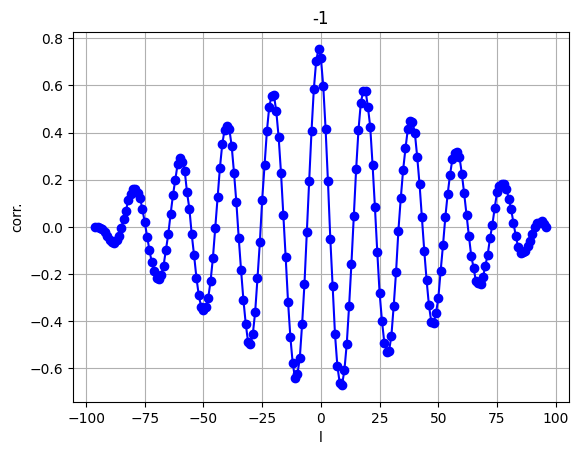

In [11]:
def plot_ECCT(time_series_X, time_series_Y, L, E, tau):

    corr_coffs, my_l_intervall = find_causality(time_series_X, time_series_Y, L, E, tau)

    max_index = corr_coffs.index(max(corr_coffs))
    max_l = my_l_intervall[max_index]

    plt.plot(my_l_intervall, corr_coffs, marker='o', linestyle='-', color='b')
    plt.xlabel('l')
    plt.ylabel('corr.')
    plt.title(max_l)
    plt.grid(True)
    plt.show()
    

plot_ECCT(time_series, time_series_new, L, E, tau)


In [12]:
# import data
datapath_for_ccm = 'C:/Users/klbal/Desktop/Internship #2/pivoted_output_2.txt'

ccm_data = pd.read_csv(datapath_for_ccm, delimiter='\t')

# define species to compare

X_baki = 'Chlamy26'

Y_baki = 'Chlamy88'

X_series = ccm_data[X_baki]

Y_series = ccm_data[Y_baki]


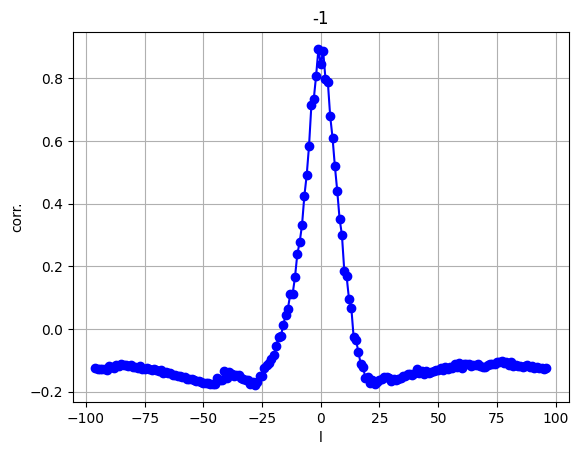

In [13]:
plot_ECCT(X_series, Y_series, L, E, tau)

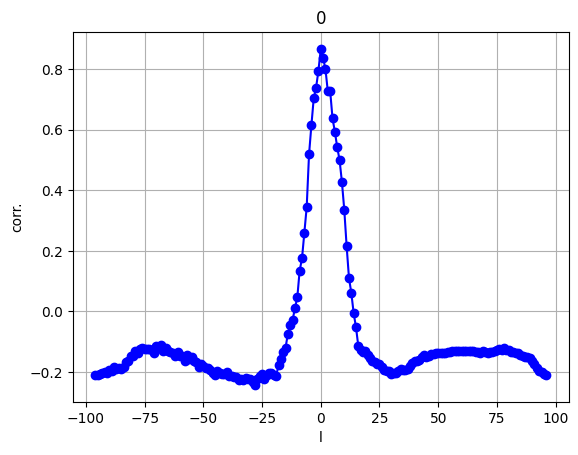

In [14]:
plot_ECCT(Y_series, X_series, L, E, tau)

In [15]:
# parameters
alpha = 1.0
beta = 0.2
gamma = 0.4
delta = 0.8

# Initial values
x0 = 1.0
y0 = 0.5

# linspace
t = np.linspace(0, 10, 100)

def model_synchrony(y, t):

    x = y[0]
    y = y[1]
    dxdt = alpha * x - beta * x * y
    dydt = gamma * x * y - delta * y

    return [dxdt, dydt]


def model_causality_xy(y, t):

    x = y[0]
    y = y[1]
    dxdt = alpha * x - beta * x * y
    dydt = gamma * x - delta * y

    return [dxdt, dydt]


y_synchrony = odeint(model_synchrony, [x0, y0], t)
y_causality_xy = odeint(model_causality_xy, [x0, y0], t)


x_synchrony = y_synchrony[:, 0].tolist()
y_synchrony = y_synchrony[:, 1].tolist()

x_causality_xy = y_causality_xy[:, 0].tolist()
y_causality_xy = y_causality_xy[:, 1].tolist()


print("Synchronie-Modell:")
print("x(t):", x_synchrony)
print("y(t):", y_synchrony)
print("\nModell mit Kausalität von x nach y:")
print("x(t):", x_causality_xy)
print("y(t):", y_causality_xy)


Synchronie-Modell:
x(t): [1.0, 1.0953832203865035, 1.2002908309325577, 1.3156448836556218, 1.442448395654773, 1.5817898590873274, 1.7348468653234, 1.9028885801814905, 2.0872762364570723, 2.2894606852148462, 2.5109754877506694, 2.753423497281984, 3.0184537980598485, 3.307724609232713, 3.6228455766897256, 3.965289566018544, 4.336259952599262, 4.736491683903533, 5.165954376176112, 5.623410666806322, 6.105761893855482, 6.607086911459792, 7.117253380770936, 7.619977206871647, 8.09027861325447, 8.4915684252803, 8.773328672099517, 8.871796193293314, 8.717983577051454, 8.257729527340972, 7.482518149881855, 6.455156674255308, 5.304005914997354, 4.177502870609033, 3.1888502580673, 2.3896676111677113, 1.7793168175852159, 1.3292324701534484, 1.0033051174786904, 0.7687123297282729, 0.5995135530960727, 0.47660760948099395, 0.3864309108755142, 0.3195130329883593, 0.2692762115267997, 0.23114374913816232, 0.20191211490125, 0.17931994968743883, 0.1617554905075006, 0.1480583381684178, 0.13738480412700804

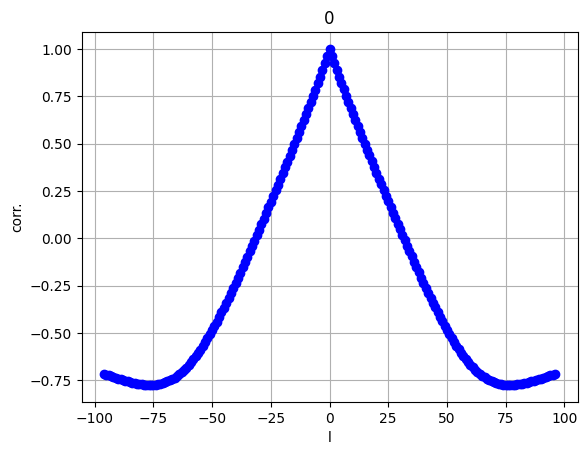

In [16]:
plot_ECCT(y_causality_xy, y_causality_xy, L, E, tau)

# 4 Species - Model

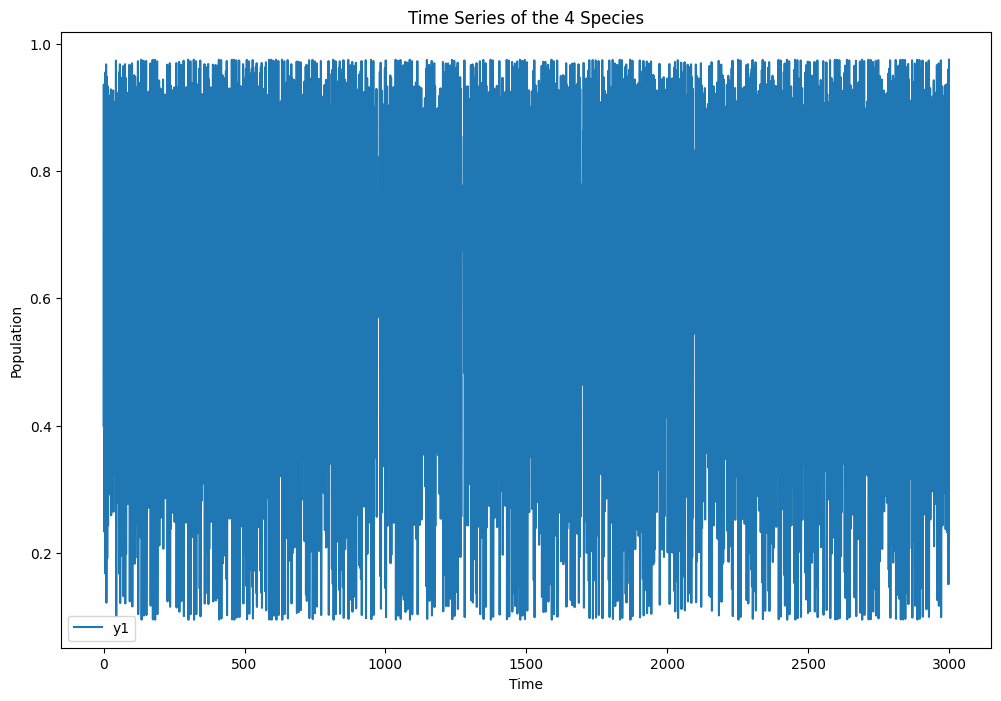

In [17]:
# Define the number of time points
T = 3000

# Initialize arrays to store the time series
y1 = np.zeros(T)
y2 = np.zeros(T)
y3 = np.zeros(T)
y4 = np.zeros(T)

# Initial conditions
y1[0] = 0.4
y2[0] = 0.4
y3[0] = 0.4
y4[0] = 0.4

# Iterate over time points to compute the values using the given equations
for t in range(T - 1):

    y1[t + 1] = y1[t] * (3.9 - 3.9 * y1[t])
    y2[t + 1] = y2[t] * (3.6 - 0.4 * y1[t] - 3.6 * y2[t])
    y3[t + 1] = y3[t] * (3.6 - 0.4 * y2[t] - 3.6 * y3[t])
    y4[t + 1] = y4[t] * (3.8 - 0.35 * y3[t] - 3.8 * y4[t])


plt.figure(figsize=(12, 8))
plt.plot(y1, label='y1')
#plt.plot(y2, label='y2')
#plt.plot(y3, label='y3')
#plt.plot(y4, label='y4')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.title('Time Series of the 4 Species')
plt.show()

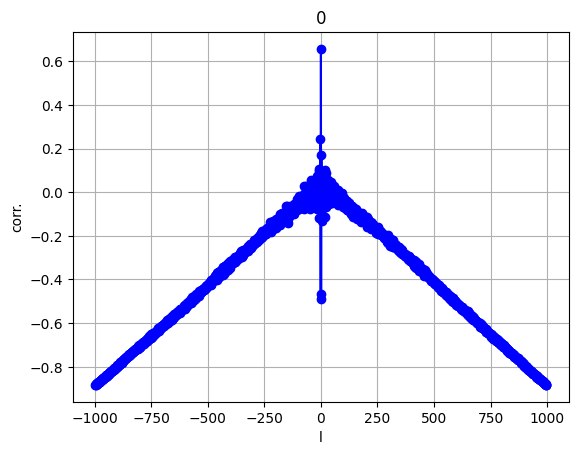

In [19]:
E = 4
tau = 1
L = 1000

plot_ECCT(y2, y1, L, E, tau)